# Steps for calculating incidence angle

Mainly, I need to geolocate the lkv file before I can call the calc_inc_angle function. 

In [7]:
# import libraries
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from rasterio.enums import Resampling

from pathlib import Path
from datetime import datetime
import tifffile as tif

import matplotlib.pyplot as plt

# uavsar code
from uavsar_pytools.convert.tiff_conversion import read_annotation
from uavsar_pytools.incidence_angle import calc_inc_angle

In [2]:
from uavsar_pytools.incidence_angle import calc_inc_angle


/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
raw_dir = '../data/snowex_lowman/slcs_raw/'
geo_dir = '../data/snowex_lowman/slcs_geocoded/'
lowman_dir = '../data/snowex_lowman/'

# llh_fp = raw_dir + 'lowman_05208_01_BU_s2_2x8.llh'
lkv_fp = geo_dir + 'lowman_05208_01_BU_s2_2x8_geolkv.tif'

<xarray.DataArray (y: 1435, x: 1864)> Size: 11MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(1435, 1864), dtype=float32)
Coordinates:
  * x            (x) float64 15kB -115.7 -115.7 -115.7 ... -115.6 -115.6 -115.6
  * y            (y) float64 11kB 43.98 43.98 43.98 43.98 ... 43.91 43.91 43.91
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        2478.0634765625
    STATISTICS_MEAN:           2086.3836623687
    STATISTICS_MINIMUM:        1578.3062744141
    STATISTICS_STDDEV:         207.21079218365
    STATISTICS_VALID_PERCENT:  52.09
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:           

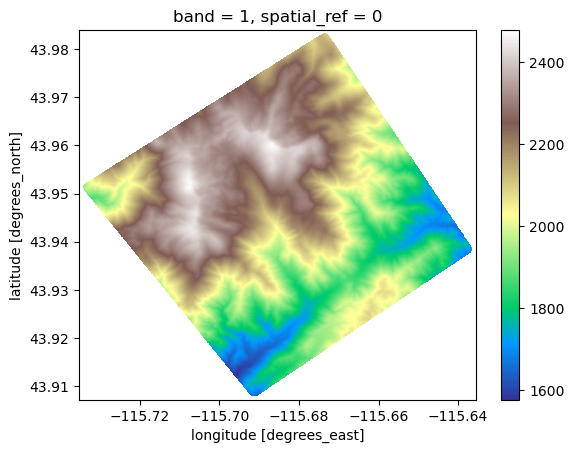

In [9]:
# arr = np.fromfile(llh_fp, dtype='f4')
res = 5  # desired resolution in meters
dem_dir = '../data/snowex_lowman/snex_qsi_lidar/'
dem = rxa.open_rasterio(dem_dir + 'SNEX20_QSI_DEM_0.5M_USIDMC_20210917_20210917.tif')
resampled_dem = dem.rio.reproject(
        dem.rio.crs, # Reproject to the same CRS
        resampling=Resampling.average, # Use average for DEM aggregation
        resolution=(res, res)
    )
reprojected_dem = resampled_dem.rio.reproject(
        'EPSG:4326', # Reproject to the CRS of the radar data
    )
reprojected_dem = reprojected_dem.squeeze()  # remove band dimension
reprojected_dem = reprojected_dem.where(reprojected_dem != dem.rio.nodata)  # set nodata values to NaN

print(reprojected_dem)
reprojected_dem.plot(cmap = 'terrain')

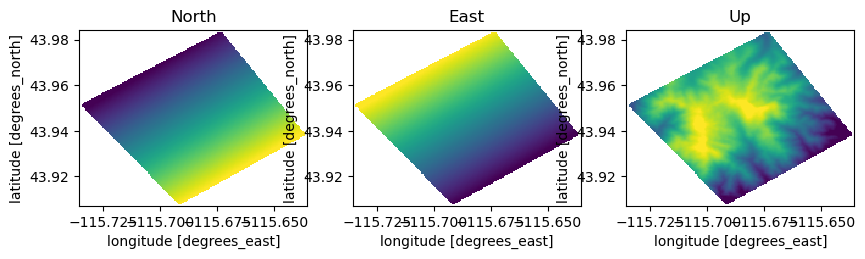

In [ ]:
lkv_spatial = rxa.open_rasterio(lkv_fp)
# print(lkv_spatial)
# print(lkv_spatial[1])
# lkv_x = lkv_spatial[1]

# lkv_spatial = dem.copy(data = lkv_spatial)
clipped = []
for i in range(3) : 
    clip = lkv_spatial[i].rio.reproject_match(reprojected_dem, 
                                              nodata = np.nan,
                                              resampling = Resampling.average)
    clip = clip.where(~np.isnan(reprojected_dem))
    clipped.append(clip)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()
titles = ('North', 'East', 'Up')

for idx in range(3) :
    # print(idx)
    ang = clipped[0].copy(data = clipped[idx])

    # downsample by factor of 10 for plotting
    ang = ang.isel(x=slice(None, None, 10), y=slice(None, None, 10))
    ax = axes[idx]
    im = ang.plot(ax=ax, robust=True, add_colorbar=False)
    ax.set_title(titles[idx])
    ax.set_aspect('equal')  # Ensures equal degree dimensions


<class 'numpy.ndarray'>


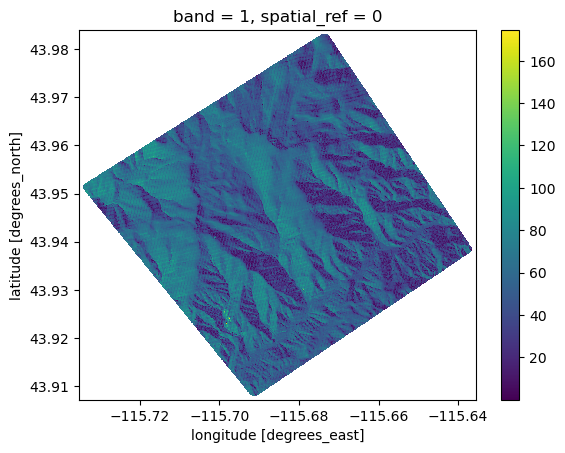

In [39]:
print(type(clipped[0].values))
# print(dem.values.shape)
inc_angle = calc_inc_angle(dem = reprojected_dem.values.squeeze(), 
               lkv_x = clipped[0].values, 
               lkv_y = clipped[1].values, 
               lkv_z = clipped[2].values, 
               pixel_size = res)
inc_spatial = clipped[0].copy(data = inc_angle)

inc_spatial.plot()